In [ ]:
import pandas as pd

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

**Model**

In [ ]:
# Define MLP Model with adjusted input dimension
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            #nn.Dropout(0.5), # Adding Dropout with a probability of 0.5 could improve the model
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.5), # Adding another Dropout layer
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)

#possible improvment by increasing layers
# self.network = nn.Sequential(
#     nn.Linear(input_dim, 256), # Increased from 128 to 256
#     nn.ReLU(),
#     nn.Linear(256, 128), # New layer
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, output_dim)
# )


In [ ]:
# Evaluate the model
def get_predictions_and_targets(loader, model):
    model.eval()  # Set the model to evaluation mode
    predictions, targets = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            targets.append(labels.numpy())
    predictions = np.vstack(predictions)
    targets = np.vstack(targets)
    return predictions, targets

In [ ]:
def evaluate_model(model, test_X, test_y, train_loader, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        predictions = model(test_X)
        test_loss = criterion(predictions, test_y)
    print(f'Test Loss: {test_loss.item()}')

    train_predictions, train_targets = get_predictions_and_targets(train_loader, model)
    test_predictions, test_targets = get_predictions_and_targets(test_loader, model)

    train_mae = mean_absolute_error(train_targets, train_predictions)
    train_mse = mean_squared_error(train_targets, train_predictions)
    test_mae = mean_absolute_error(test_targets, test_predictions)
    test_mse = mean_squared_error(test_targets, test_predictions)

    print(f"Training MAE: {train_mae}, Training MSE: {train_mse}")
    print(f"Testing MAE: {test_mae}, Testing MSE: {test_mse}")


**Main**

In [ ]:
if __name__ == "__main__":
  # Load the dataset
  # Link to 6 weather datasets
  url_ottawa = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawa_daily.csv"
  url_ottawa_south = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_ottawasouth_daily.csv"
  url_gatineau = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_gatineau_daily.csv"
  url_chelsea = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_chelsea_daily.csv"
  url_kemptville = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_kemptville_daily.csv"
  url_renfrew = "https://raw.githubusercontent.com/noobstang/NNtraining/master/Weather49Sets/weatherstats_renfrew_daily.csv"

  # Load and Preprocess Data
  url = url_ottawa
  data = pd.read_csv(url)


  data['date'] = pd.to_datetime(data['date'])

  # Filter data for dates between May 1st and November 30th for each year
  filtered_data = data[(data['date'].dt.month >= 5) & (data['date'].dt.month <= 11)]
  data_filtered = data[(data['date'].dt.year >= 2010) & (data['date'].dt.year <= 2020)]

  # Select the required columns and preprocess
  columns_required = ['avg_hourly_temperature', 'precipitation', 'avg_hourly_pressure_station', 'solar_radiation']

  #only Ottawa and ottawa south have solar_radiation
  #columns_required = ['avg_hourly_temperature', 'precipitation', 'avg_hourly_pressure_station', 'daylight']

  data_filtered = data_filtered[columns_required].dropna()

  # Scale the data
  scaler = MinMaxScaler(feature_range=(0, 1))
  data_scaled = scaler.fit_transform(data_filtered)

  # Convert to supervised learning problem with a window size of 3DAYS
  data_supervised = series_to_supervised(data_scaled, 3, 1)

  # Split the dataset
  n_obs = 3 * 4  # Update for 3DAYS window size
  values = data_supervised.values
  n_train_days = int(len(values) * 0.8)
  train = values[:n_train_days, :]
  test = values[n_train_days:, :]
  train_X, train_y = train[:, :n_obs], train[:, -4:]
  test_X, test_y = test[:, :n_obs], test[:, -4:]

  # Convert to tensors
  train_X = torch.tensor(train_X, dtype=torch.float32)
  train_y = torch.tensor(train_y, dtype=torch.float32)
  test_X = torch.tensor(test_X, dtype=torch.float32)
  test_y = torch.tensor(test_y, dtype=torch.float32)

  # DataLoader
  train_dataset = TensorDataset(train_X, train_y)
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_dataset = TensorDataset(test_X, test_y)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  # Initialize the model with the updated input dimension
  model = MLP(12, 4)  # Update for 3DAYS window size
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Training loop
  epochs = 50  #use different epoch number to improve
  for epoch in range(epochs):
      model.train()
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          output = model(inputs)
          loss = criterion(output, targets)
          loss.backward()
          optimizer.step()
      print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


  evaluate_model(model, test_X, test_y, train_loader, test_loader, criterion)


<ipython-input-69-a24d0867866c>:13: DtypeWarning: Columns (46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


Epoch 1/50, Loss: 0.02433698996901512
Epoch 2/50, Loss: 0.016389399766921997
Epoch 3/50, Loss: 0.01540902629494667
Epoch 4/50, Loss: 0.013951965607702732
Epoch 5/50, Loss: 0.011227840557694435
Epoch 6/50, Loss: 0.014441181905567646
Epoch 7/50, Loss: 0.012829219922423363
Epoch 8/50, Loss: 0.013984748162329197
Epoch 9/50, Loss: 0.012491447851061821
Epoch 10/50, Loss: 0.01015695370733738
Epoch 11/50, Loss: 0.015046578831970692
Epoch 12/50, Loss: 0.012065563350915909
Epoch 13/50, Loss: 0.010717104189097881
Epoch 14/50, Loss: 0.014191722497344017
Epoch 15/50, Loss: 0.01375599205493927
Epoch 16/50, Loss: 0.013869354501366615
Epoch 17/50, Loss: 0.014270740561187267
Epoch 18/50, Loss: 0.013757644221186638
Epoch 19/50, Loss: 0.013904009014368057
Epoch 20/50, Loss: 0.014351117424666882
Epoch 21/50, Loss: 0.012677781283855438
Epoch 22/50, Loss: 0.010620574466884136
Epoch 23/50, Loss: 0.013974091038107872
Epoch 24/50, Loss: 0.009916366077959538
Epoch 25/50, Loss: 0.013960224576294422
Epoch 26/50, 



```
Ottawa Region, 3 day window, 2010-2020
Epoch 50/50, Loss: 0.01004338450729847
Test Loss: 0.010190354660153389
Training MAE: 0.07709593325853348, Training MSE: 0.01208843756467104
Testing MAE: 0.07287008315324783, Testing MSE: 0.01019035279750824

Ottawa South Region, 3 day window, 2010-2020
Epoch 50/50, Loss: 0.008148330263793468
Test Loss: 0.009776744060218334
Training MAE: 0.07572181522846222, Training MSE: 0.011844922788441181
Testing MAE: 0.07088617980480194, Testing MSE: 0.00977674312889576
```



**Testing**

In [ ]:
# Filter the dataset for testing on the year 2023
test_data = filtered_data[filtered_data['date'].dt.year == 2023]

# Generate predictions for 2023
predictions = model(test_X).detach().numpy()
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(test_y.numpy())

In [ ]:
# Calculate MAE and RMSE for each feature and display comparisons
feature_names = ['avg_hourly_temperature', 'precipitation', 'avg_hourly_pressure_station', 'solar_radiation']
actual_feature_names = ['ActualAvgHourlyTemperature', 'ActualPrecipitation', 'ActualAvgHourlyPressureStation', 'ActualSolarRadiation']
predicted_feature_names = ['Predicted Temperature', 'Predicted Precipitation', 'Predicted Pressure ', 'Predicted Solar Radiation']

# Sample comparison for each feature
test_dates = test_data['date'].reset_index(drop=True)[:len(predictions)]

for i, feature_name in enumerate(feature_names):
    # Calculate and print MAE and RMSE
    mae = mean_absolute_error(y_test_scaled[:, i], predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_scaled[:, i], predictions[:, i]))
    print(f'{feature_name.title()} - MAE: {mae}')
    print(f'{feature_name.title()} - RMSE: {rmse}\n')

    # Prepare comparison data for the first 5 rows
    comparison_df = pd.DataFrame({
        'Date': test_dates[:5],
        actual_feature_names[i]: y_test_scaled[:5, i],
        predicted_feature_names[i]: predictions[:5, i]
    })

    print(f"Comparison for {feature_name.title()}")
    print(comparison_df, '\n')
    print('-' * 80)


Avg_Hourly_Temperature - MAE: 3.1483137607574463
Avg_Hourly_Temperature - RMSE: 4.212202072143555

Comparison for Avg_Hourly_Temperature
        Date  ActualAvgHourlyTemperature  Predicted Temperature
0 2023-11-30                   -5.620001              -6.476257
1 2023-11-29                   -2.410000              -3.466543
2 2023-11-28                   -6.440000              -4.535174
3 2023-11-27                    1.080000              -5.580198
4 2023-11-26                   -4.260000               0.148676 

--------------------------------------------------------------------------------
Precipitation - MAE: 2.799971342086792
Precipitation - RMSE: 4.659529685974121

Comparison for Precipitation
        Date  ActualPrecipitation  Predicted Precipitation
0 2023-11-30                  1.2                 3.261736
1 2023-11-29                  0.2                 5.875482
2 2023-11-28                  0.0                 1.458872
3 2023-11-27                  2.6                -0

**Graphs and visualizations**

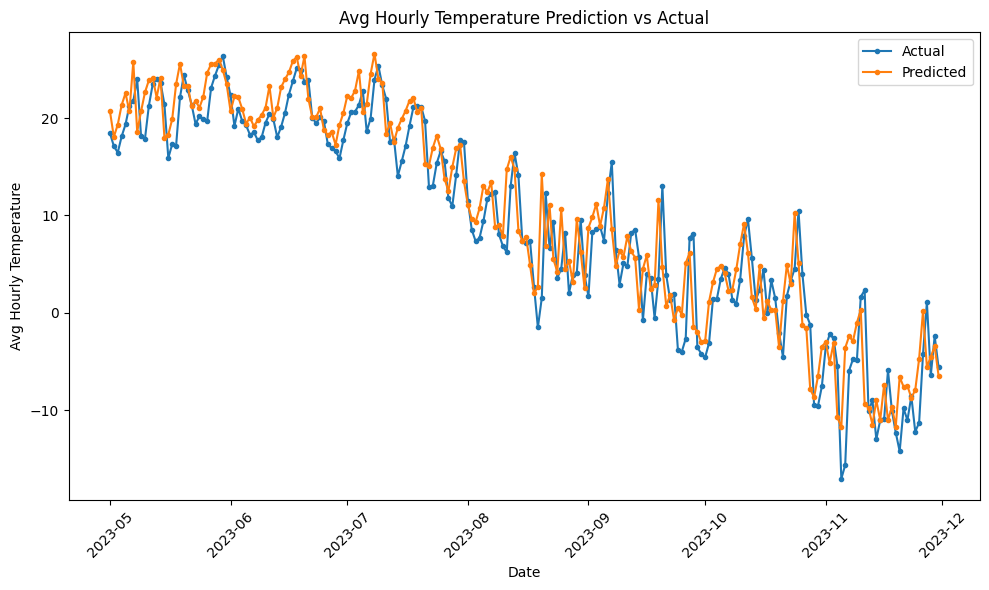

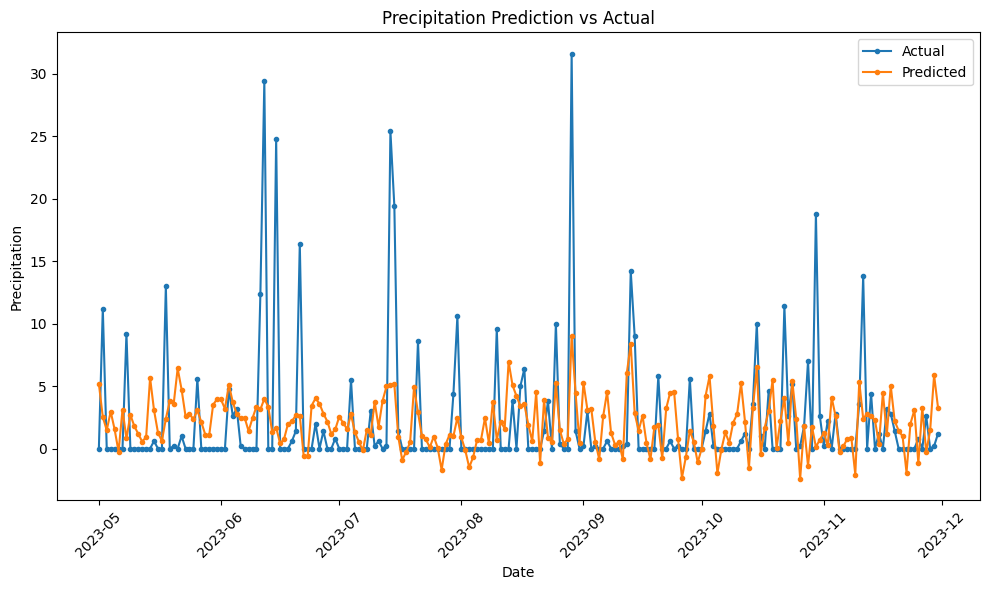

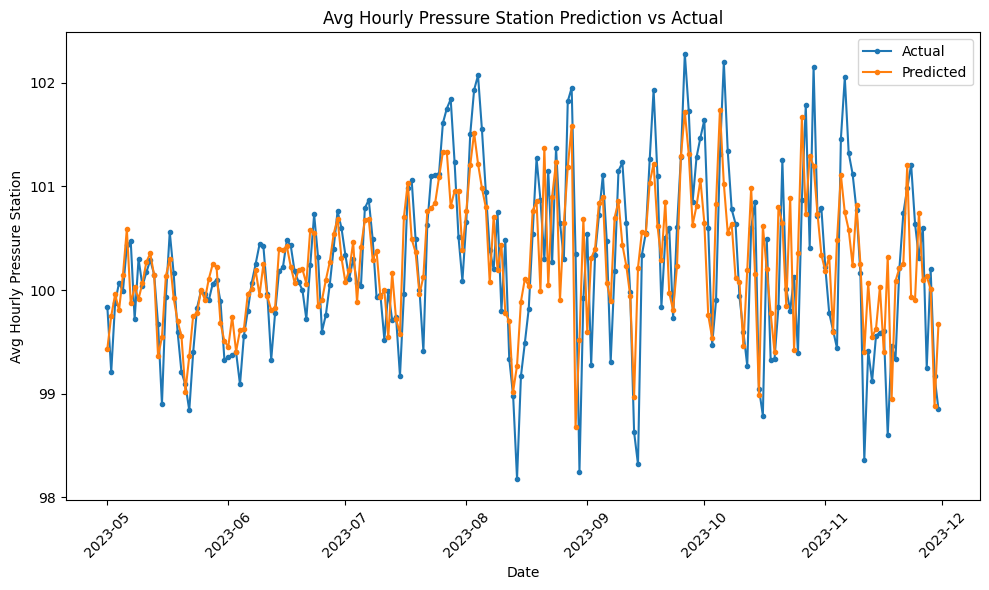

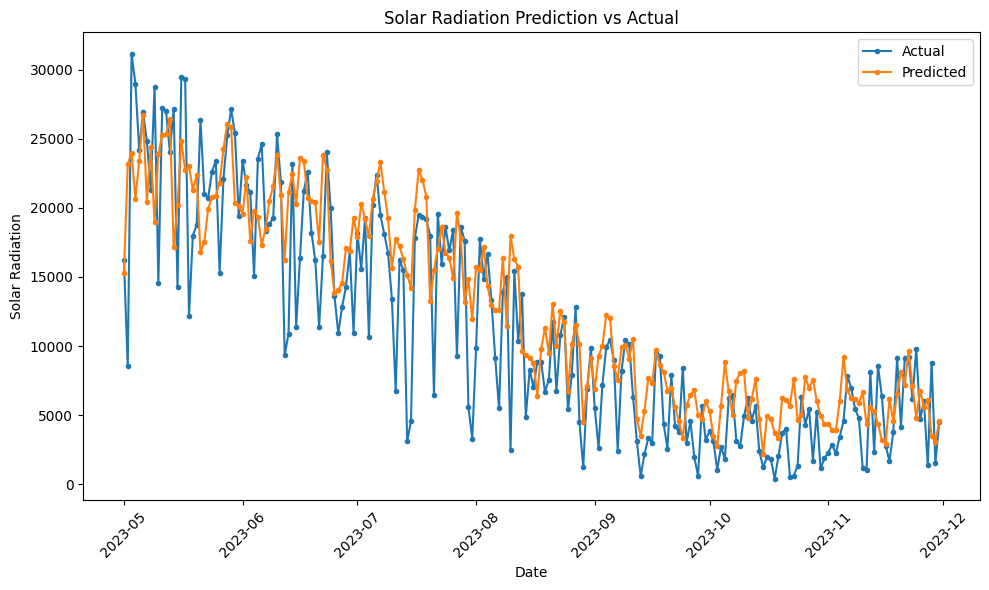

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' and 'y_test_scaled' are your model's predictions and actual values, respectively, scaled back to their original range

feature_names = ['Avg Hourly Temperature','Precipitation','Avg Hourly Pressure Station','Solar Radiation',]
test_dates = test_data['date'].reset_index(drop=True)[:len(predictions)]

# Ensure test_dates, predictions, and y_test_scaled are all aligned
min_length = min(len(test_dates), predictions.shape[0], y_test_scaled.shape[0])

# Trim the arrays to match the smallest length
test_dates_trimmed = test_dates[:min_length]
predictions_trimmed = predictions[:min_length, :]
y_test_scaled_trimmed = y_test_scaled[:min_length, :]

# Update the plotting code to use the trimmed arrays
for i, feature_name in enumerate(feature_names):
    plt.figure(figsize=(10, 6))
    plt.plot(test_dates_trimmed, y_test_scaled_trimmed[:, i], label='Actual', marker='.', zorder=-1)
    plt.plot(test_dates_trimmed, predictions_trimmed[:, i], label='Predicted', marker='.', zorder=1)
    plt.title(f'{feature_name} Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

